In [1]:
from functools import partial

from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import dimensionless, galactic, UnitSystem

import jax
import jax.numpy as jnp

from jax.config import config
config.update("jax_enable_x64", True)

import scienceplots
import cmasher as cmr
plt.style.use('science')

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)

In [3]:
class Potential:
    
    def __init__(self, units, params):
        if units is None:
            units = dimensionless
        self.units = UnitSystem(units)
        
        if self.units == dimensionless:
            self._G = 1
        else:
            self._G = G.decompose(self.units).value
        
        for name, param in params.items():
            if hasattr(param, 'unit'):
                param = param.decompose(self.units).value
            setattr(self, name, param)
    
    @partial(jax.jit, static_argnums=(0,))
    def gradient(self, xyz):
        grad_func = jax.grad(self.potential)
        return grad_func(xyz)
    
    @partial(jax.jit, static_argnums=(0,))
    def density(self, xyz):
        lap = jnp.trace(jax.hessian(self.potential)(xyz))
        return lap / (4 * jnp.pi * self._G)
    
    @partial(jax.jit, static_argnums=(0,))
    def acceleration(self, xyz):
        return -self.gradient(xyz)
    

class Kepler(Potential):
    
    def __init__(self, m, units=None):
        super().__init__(units, {'m': m})
    
    @partial(jax.jit, static_argnums=(0,))
    def potential(self, xyz):
        r = jnp.linalg.norm(xyz, axis=0)
        return - self._G * self.m / r
    
    
class Hernquist(Potential):
    
    def __init__(self, m, a, units=None):
        super().__init__(units, {'m': m, 'a': a})
        
    @partial(jax.jit, static_argnums=(0,))
    def potential(self, xyz):
        r = jnp.linalg.norm(xyz, axis=0)
        return - self._G * self.m / (r + self.a)
    
    
class Isochrone(Potential):
    
    def __init__(self, m, a, units=None):
        super().__init__(units, {'m': m, 'a': a})
    
    @partial(jax.jit, static_argnums=(0,))
    def potential(self, xyz):
        r = jnp.linalg.norm(xyz, axis=0)
        return - self._G * self.m / (self.a + jnp.sqrt(r**2 + self.a**2))

In [4]:
pot = Hernquist(m=1e12, a=10,units=usys)
xyz = jnp.array([1., 2., 0.])

pot.gradient(xyz)
pot.acceleration(xyz)

Array([-0.0134369 , -0.02687381, -0.        ], dtype=float64)

In [5]:
def leapfrog_step(func, y0, t0, dt, a0):
    ndim = y0.shape[0] // 2
    tf = t0 + dt
    
    x0 = y0[:ndim]
    v0 = y0[ndim:]
    
    v1_2 = v0 + a0 * dt / 2.
    xf = x0 + v1_2 * dt
    af = - func(xf, tf)
    
    vf = v1_2 + af * dt / 2
    
    return tf, jnp.concatenate((xf, vf)), af

@partial(jax.jit, static_argnames=['potential_gradient', 'args'])
def leapfrog_run(w0, ts, potential_gradient, args=()):
    func_ = lambda y, t: potential_gradient(y, *args)
    
    def scan_fun(carry, t):
        i, y0, t0, dt, a0 = carry
        tf, yf, af = leapfrog_step(func_, y0, t0, dt, a0)
        return [i + 1, yf, tf, dt, af], yf
    
    ndim = w0.shape[0] // 2
    a0 = func_(w0[:ndim], ts[0])
    init_carry = [0, w0, t0, dt, a0]
    _, ws = jax.lax.scan(scan_fun, init_carry, ts[1:])
    res_ws = jnp.concatenate((w0[None], ws))
    
    return res_ws



In [6]:
(200*u.km/u.s).to(u.kpc/u.Myr)

<Quantity 0.20454243 kpc / Myr>

In [13]:
w0 = jnp.array([10, 0, 0, 0, .204, 0])
t0 = 0
dt = 0.1
n_steps = 10000
ts = np.arange(t0, t0 + dt * n_steps + dt/10., dt)
ws_jax = leapfrog_run(w0, ts, pot.gradient)


    

In [8]:
run_grad = jax.jacfwd(leapfrog_run)
Jac = run_grad(w0, ts, potential_gradient=pot.gradient)

In [7]:
import jax.random as random 
key = random.PRNGKey(0)  # Initialize a random key
num_orbits = 6000
ndim = 3
w0 = random.uniform(key, (num_orbits, 2 * ndim))  # Generate random initial positions and velocities
orbs = []#jnp.array([])
final_snap = jnp.zeros((num_orbits,6))
for i in range(len(w0)):
    wcurr = w0[i]
    ws_jax = leapfrog_run(wcurr, ts, pot.gradient)
    orbs.append(ws_jax)
    
    final_snap = final_snap.at[i].set(ws_jax[-1,:])
    
    

NameError: name 'ts' is not defined

In [6]:
def compute_orbit_and_gradients(params,w0,dt,n_steps,units):
    pot = Hernquist(m=params['m'], a=params['a'],units=units,)  # Create the potential with the given parameters
    
    # Example Orbit:
    #w0 = jnp.array([10, 0, 0, 0, .204, 0])
    t0 = 0
    #dt = 0.1
    #n_steps = 10000
    ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
    
    ### Compute the orbit with the provided potential
    ws_jax = leapfrog_run(w0, ts, pot.gradient)
    
    # Compute the gradient of the final position with respect to the potential parameters
    def gradient_fn(params):
        pot_with_params = Hernquist(m=params['m'], a=params['a'],units=units)
        ws_with_params = leapfrog_run(w0, ts, pot_with_params.gradient)
        final_position = ws_with_params[-1, :]  # Extract final position
        return final_position
    
    # Compute the gradient using JAX's autodiff
    gradient = jax.jacfwd(gradient_fn)(params)
    
    return ws_jax, gradient

In [15]:
# Example parameter values
params = {'m': 1e10, 'a': 10.}
w0 = jnp.array([15., 0., 0, 0, .204, 0])
dt = 0.1
n_steps = 10_000
result_ws, param_gradients = compute_orbit_and_gradients(params,w0,dt,n_steps,usys)


In [12]:
result_ws[-1,:], param_gradients['a']

(Array([ 9.06855039e+00,  1.97839565e+02,  0.00000000e+00, -6.48383078e-03,
         1.95978592e-01,  0.00000000e+00], dtype=float64),
 Array([3.92064633e-01, 3.16509740e-01, 0.00000000e+00, 4.15890756e-04,
        3.73949068e-04, 0.00000000e+00], dtype=float64))

In [13]:
result_ws[-1,:] + param_gradients['a']*0.25

Array([ 9.16656655e+00,  1.97918693e+02,  0.00000000e+00, -6.37985809e-03,
        1.96072079e-01,  0.00000000e+00], dtype=float64)

In [14]:
# Example parameter values
params = {'m': 1e10, 'a': 10.25}
result_ws, param_gradients = compute_orbit_and_gradients(params,w0,dt,n_steps,usys)
result_ws[-1]

Array([ 9.16529728e+00,  1.97917817e+02,  0.00000000e+00, -6.38118505e-03,
        1.96071085e-01,  0.00000000e+00], dtype=float64)

In [15]:
(.104*u.kpc/u.Myr).to(u.km/u.s)

<Quantity 101.69039105 km / s>

In [28]:
a_arr = jnp.linspace(10,11,30)
w0 = jnp.array([25., 0., 0, 0.01, .104, -0.004])
dt = 0.1
t0 = 0.
n_steps = 30_000
Delta_a = jnp.diff(a_arr)[0]
predicted_wf = jnp.zeros((len(a_arr),6))
true_wf = jnp.zeros((len(a_arr)-1,6))
for i in range(len(a_arr)):
    params = {'m': 5e11, 'a': a_arr[i]}
    result_ws, param_gradients = compute_orbit_and_gradients(params,w0,dt,n_steps,usys)
    pred = result_ws[-1] + param_gradients['a']*Delta_a 
    predicted_wf = predicted_wf.at[i,:].set( pred )
    if i > 0:
        true_wf = true_wf.at[i-1,:].set(result_ws[-1])
    
    

    

    
    

In [29]:
Delta_a

Array(0.03448276, dtype=float64)

In [85]:
true_wf.shape

(29, 6)

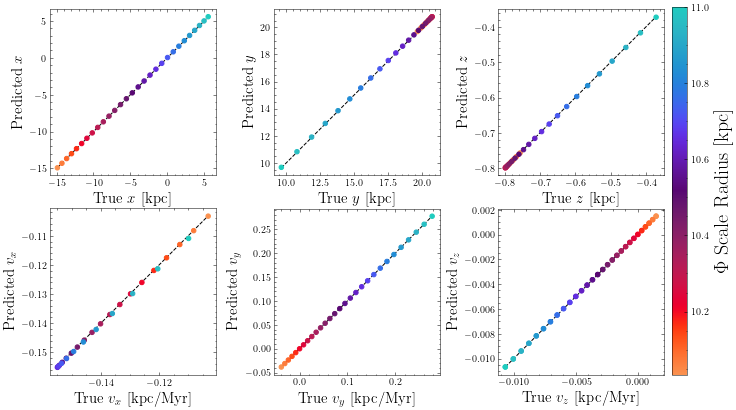

In [128]:
fig, ax = plt.subplots(2,3)
ax_flat = ax.flatten()
fig.set_size_inches(11,7)
for dim in range(6):
    xx = np.linspace(true_wf[:,dim].min(),true_wf[:,dim].max(),50)
    ax_flat[dim].plot(xx,xx,color='k',ls='--',zorder=0)

    ax_flat[dim].scatter(true_wf[:,dim], predicted_wf[:-1,dim],c=a_arr[1:],s=20,cmap=cmr.guppy)
    ax_flat[dim].set_aspect('equal')
fig.subplots_adjust(hspace=0.1,wspace=.35)
ax_flat[0].set_xlabel(r'True $x$ [kpc]',fontsize=15)
ax_flat[0].set_ylabel(r'Predicted $x$',fontsize=15)

ax_flat[1].set_xlabel(r'True $y$ [kpc]',fontsize=15)
ax_flat[1].set_ylabel(r'Predicted $y$',fontsize=15)

ax_flat[2].set_xlabel(r'True $z$ [kpc]',fontsize=15)
ax_flat[2].set_ylabel(r'Predicted $z$',fontsize=15)

ax_flat[3].set_xlabel(r'True $v_x$ [kpc/Myr]',fontsize=15)
ax_flat[3].set_ylabel(r'Predicted $v_x$',fontsize=15)

ax_flat[4].set_xlabel(r'True $v_y$ [kpc/Myr]',fontsize=15)
ax_flat[4].set_ylabel(r'Predicted $v_y$',fontsize=15)

ax_flat[5].set_xlabel(r'True $v_z$ [kpc/Myr]',fontsize=15)
ax_flat[5].set_ylabel(r'Predicted $v_z$',fontsize=15)

# Add a colorbar on the right of the subplots
cax = fig.add_axes([0.91, 0.14, 0.02, 0.73])  # Adjust the position and size of the colorbar
cbar = plt.colorbar(ax_flat[dim].scatter(true_wf[:,dim], predicted_wf[:-1,dim],c=a_arr[1:],s=20,cmap=cmr.guppy), cax=cax, orientation='vertical')
cbar.set_label('$\Phi$ Scale Radius [kpc]',fontsize=20)  # Set the label for the colorbar
##plt.savefig('TaylorExpansion_PotentialFinalSnap.pdf',bbox_inches='tight')



In [7]:
mass_arr = 10**jnp.linspace(np.log10(1e11),np.log10(5e11),100)
w0 = jnp.array([25., 0., 0, 0.01, .104, -0.004])
dt = 0.05
t0 = 0
n_steps = 30_000
Delta_a = jnp.diff(mass_arr)[0]
predicted_wf = jnp.zeros((len(mass_arr),6))
true_wf = jnp.zeros((len(mass_arr)-1,6))
for i in range(len(mass_arr)):
    params = {'m': mass_arr[i], 'a': 10.}
    result_ws, param_gradients = compute_orbit_and_gradients(params,w0,dt,n_steps,usys)
    pred = result_ws[-1] + param_gradients['m']*Delta_a 
    predicted_wf = predicted_wf.at[i,:].set( pred )
    if i > 0:
        true_wf = true_wf.at[i-1,:].set(result_ws[-1])
    
    

    

    
    

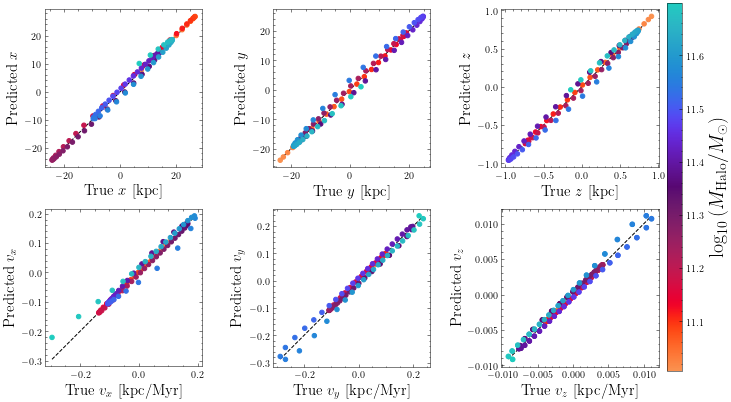

In [9]:
fig, ax = plt.subplots(2,3)
ax_flat = ax.flatten()
fig.set_size_inches(11,7)
for dim in range(6):
    xx = np.linspace(true_wf[:,dim].min(),true_wf[:,dim].max(),50)
    ax_flat[dim].plot(xx,xx,color='k',ls='--',zorder=0)

    ax_flat[dim].scatter(true_wf[:,dim], predicted_wf[:-1,dim],c=np.log10(mass_arr[1:]),s=20,cmap=cmr.guppy)
    ax_flat[dim].set_aspect('equal')
fig.subplots_adjust(hspace=0.1,wspace=.45)
ax_flat[0].set_xlabel(r'True $x$ [kpc]',fontsize=15)
ax_flat[0].set_ylabel(r'Predicted $x$',fontsize=15)

ax_flat[1].set_xlabel(r'True $y$ [kpc]',fontsize=15)
ax_flat[1].set_ylabel(r'Predicted $y$',fontsize=15)

ax_flat[2].set_xlabel(r'True $z$ [kpc]',fontsize=15)
ax_flat[2].set_ylabel(r'Predicted $z$',fontsize=15)

ax_flat[3].set_xlabel(r'True $v_x$ [kpc/Myr]',fontsize=15)
ax_flat[3].set_ylabel(r'Predicted $v_x$',fontsize=15)

ax_flat[4].set_xlabel(r'True $v_y$ [kpc/Myr]',fontsize=15)
ax_flat[4].set_ylabel(r'Predicted $v_y$',fontsize=15)

ax_flat[5].set_xlabel(r'True $v_z$ [kpc/Myr]',fontsize=15)
ax_flat[5].set_ylabel(r'Predicted $v_z$',fontsize=15)

# Add a colorbar on the right of the subplots
cax = fig.add_axes([0.91, 0.14, 0.02, 0.73])  # Adjust the position and size of the colorbar
cbar = plt.colorbar(ax_flat[dim].scatter(true_wf[:,dim], predicted_wf[:-1,dim],c=np.log10(mass_arr[1:]),s=20,cmap=cmr.guppy), cax=cax, orientation='vertical')
cbar.set_label(r'$\log_{10}\left(M_{\mathrm{Halo}} / M_{\odot}\right)$',fontsize=20)  # Set the label for the colorbar
###plt.savefig('TaylorExpansion_PotentialFinalSnap_MASS.pdf',bbox_inches='tight')



In [333]:
true_wf.shape

(9, 6)

In [70]:
jnp.concatonate(orbs)

AttributeError: module 'jax.numpy' has no attribute 'concatonate'

In [36]:
def leapfrog_step(func, y0, t0, dt, a0):
    num_orbits, ndim = y0.shape[0] // 2, y0.shape[1] // 2
    tf = t0 + dt
    
    x0 = y0[:, :ndim]
    v0 = y0[:, ndim:]
    
    v1_2 = v0 + a0 * dt / 2.0
    xf = x0 + v1_2 * dt
    af = -func(xf, tf)
    
    vf = v1_2 + af * dt / 2.0
    
    return tf, jnp.concatenate((xf, vf), axis=1), af

@partial(jax.jit, static_argnames=['potential_gradient', 'args'])
def leapfrog_run(w0, ts, potential_gradient, args=()):
    num_orbits, ndim = w0.shape[0], w0.shape[1] // 2
    func_ = lambda y, t: potential_gradient(y, *args)
    
    def scan_fun(carry, t):
        i, y0, t0, dt, a0 = carry
        tf, yf, af = leapfrog_step(func_, y0, t0, dt, a0)
        return [i + 1, yf, tf, dt, af], yf
    
    a0 = func_(w0[:, :ndim], ts[0])
    init_carry = [0, w0, t0, dt, a0]
    _, ws = jax.lax.scan(scan_fun, init_carry, ts[1:])
    res_ws = jnp.concatenate((w0[:, None], ws), axis=1)
    
    return res_ws

# Define initial conditions for multiple orbits (batched)
num_orbits = 5  # Number of orbits
ndim = 3  # Number of dimensions

import jax.random as random 
key = random.PRNGKey(0)  # Initialize a random key
w0 = random.uniform(key, (num_orbits, 2 * ndim))  # Generate random initial positions and velocities

# Define time steps
t0 = 0.0
dt = 0.01
n_steps = 1000
ts = jnp.arange(t0, t0 + n_steps * dt, dt)

# Integrate multiple orbits
result = leapfrog_run(w0, ts, pot.gradient)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (3,).

In [42]:
import jax.random as random 
key = random.PRNGKey(0)  # Initialize a random key
w0 = random.uniform(key, (num_orbits, 2 * ndim))  # Generate random initial positions and velocities


In [34]:
w0.shape

(5, 6)